## Tokenizer

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)
import random

In [18]:
StT = {
    "0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7, "8": 8, "9": 9,
    "NumBeg": 10, "NumEnd": 11, "*": 12, "+": 13, "=": 14, "ThinkBeg": 15, "ThinkEnd": 16, "Eos": 17
}

TtS = {v: k for k, v in StT.items()}

def tokenize(s):
    out = []
    num = False
    past = ""
    for c in s:
        chars = past + c
        if chars in StT:
            tok = StT[chars]
            if tok < 10:
                if not num:
                    out.append(StT["NumBeg"])
                    num = True
                out.append(tok)
            else:
                if num:
                    out.append(StT["NumEnd"])
                    num = False
                out.append(tok)
            past = ""
        else:
            past += c

    return out + [StT["Eos"]]

def detokenize(toks):
    out = []
    num = False
    for tok in toks:
        if tok == 17:
            break
        
        if tok == 10 or tok == 11 or (tok >= 15 and tok <= 17) :
            continue
        out.append(TtS[tok])

    return "".join(out)

example = "123+456*6="
print(tokenize(example))
print(detokenize(tokenize(example)))


[10, 1, 2, 3, 11, 13, 10, 4, 5, 6, 11, 12, 10, 6, 11, 14, 17]
123+456*6=


## Dataset

In [4]:
def step_mul(length):
    a = [random.randint(0,9) for i in range(length)]
    b = [random.randint(0,9) for i in range(length)]
    # a = [9, 9, 9]
    # b = [9, 9, 9]

    val_a = int(''.join(str(d) for d in a))
    val_b = int(''.join(str(d) for d in b))
    if val_a < val_b:
        val_a, val_b = val_b, val_a
        a, b = b, a
    
    string = f"{val_a}*{val_b}=ThinkBeg"

    steps_eq = []
    for i in range(length):
        a_i = a[i] * 10**(length-i-1)
        # a_i = str(a[i]) 
        string += f"{a_i}*{val_b}+"
        steps_eq.append(str(a_i*val_b)+"+")

    string = string[:-1] + "=" + "".join(steps_eq)[:-1] + "=" + "ThinkEnd" + str(val_a*val_b)

    return string
    # print(out)

eq = step_mul(3)
print(eq)
tokenize(eq)
len(tokenize(eq))

536*62=ThinkBeg500*62+30*62+6*62=31000+1860+372=ThinkEnd33232


71

In [5]:
class MulDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 100000 # ...
    
    def get_vocab_size(self):
        return len(StT)
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 79

    def __getitem__(self, idx):
        while True:
            rai = tokenize(step_mul(self.length))
            h = hash(str(rai[:1+2*(self.length+2)]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        if len(rai) < self.get_block_size():
            rai += [StT["Eos"]] * (self.get_block_size() - len(rai))
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*(self.length+2)+1] = -1
        return x, y

In [6]:
# print an example instance of the dataset
train_dataset = MulDataset('train')
test_dataset = MulDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([10,  4,  9,  5, 11, 12, 10,  3,  7,  8, 11, 14, 15, 10,  4,  0,  0, 11,
        12, 10,  3,  7,  8, 11, 13, 10,  9,  0, 11, 12, 10,  3,  7,  8, 11, 13,
        10,  5, 11, 12, 10,  3,  7,  8, 11, 14, 10,  1,  5,  1,  2,  0,  0, 11,
        13, 10,  3,  4,  0,  2,  0, 11, 13, 10,  1,  8,  9,  0, 11, 14, 16, 10,
         1,  8,  7,  1,  1,  0])
10 -1
4 -1
9 -1
5 -1
11 -1
12 -1
10 -1
3 -1
7 -1
8 -1
11 -1
14 15
15 10
10 4
4 0
0 0
0 11
11 12
12 10
10 3
3 7
7 8
8 11
11 13
13 10
10 9
9 0
0 11
11 12
12 10
10 3
3 7
7 8
8 11
11 13
13 10
10 5
5 11
11 12
12 10
10 3
3 7
7 8
8 11
11 14
14 10
10 1
1 5
5 1
1 2
2 0
0 0
0 11
11 13
13 10
10 3
3 4
4 0
0 2
2 0
0 11
11 13
13 10
10 1
1 8
8 9
9 0
0 11
11 14
14 16
16 10
10 1
1 8
8 7
7 1
1 1
1 0
0 17


## Model

In [40]:
from mingpt.model import GPT

HEADS = 8
LAYERS = 12
EMBEDDING_DIM = 256

model_config = GPT.get_default_config()
model_config.model_type = None
# model_config.model_type = 'gpt-nano'
model_config.n_head = HEADS
model_config.n_layer = LAYERS
model_config.n_embd = EMBEDDING_DIM
print (model_config)

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

model_type: None
n_layer: 12
n_head: 8
n_embd: 256
vocab_size: None
block_size: None
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 9.50M


In [58]:
import os

# make sure the model directory exists
if not os.path.exists(f'../weights/elasitc/el_mul_{HEADS}_{LAYERS}'):
    os.makedirs(f'../weights/elasitc/el_mul_{HEADS}_{LAYERS}')
    model.load_state_dict(torch.load(f'../weights/elastic/el_mul_{HEADS}_{LAYERS}/model.pth'))

In [59]:
print (model_config.n_head, model_config.n_layer, model_config.n_embd)

8 12 256


In [62]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-6 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
# train_config.batch_size = 32
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


In [63]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.04060
iter_dt 435.05ms; iter 100: train loss 0.02424
iter_dt 430.29ms; iter 200: train loss 0.02249
iter_dt 437.78ms; iter 300: train loss 0.02493
iter_dt 435.56ms; iter 400: train loss 0.02429
iter_dt 430.29ms; iter 500: train loss 0.02646
iter_dt 436.54ms; iter 600: train loss 0.02481
iter_dt 437.03ms; iter 700: train loss 0.02286


KeyboardInterrupt: 

## Evaluation

In [64]:
# now let's perform some evaluation
model.eval()
None

In [46]:
class EvalMulDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 100000 # ...
    
    def get_vocab_size(self):
        return len(StT)
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 79

    def __getitem__(self, idx):
        while True:
            rai = tokenize(step_mul(self.length))
            h = hash(str(rai[:1+2*(self.length+2)]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)[:rai.index(StT["="])+1]
        y = torch.tensor(rai[1:], dtype=torch.long)[rai.index(StT["ThinkEnd"]):]
        
        # we only want to predict at output locations, mask out the loss at the input locations
        return x, y
    
eval_train_dataset = EvalMulDataset('train')
eval_test_dataset = EvalMulDataset('test')
x, y = eval_train_dataset[0]

print (x)
print (y)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([10,  6,  2,  4, 11, 12, 10,  5,  3,  4, 11, 14])
tensor([10,  3,  3,  3,  2,  1,  6, 17])
10 10
6 3
2 3
4 3
11 2
12 1
10 6
5 17


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model_accuracy(model, eval_dataset, n = 100):
    model.eval()
    correct = 0
    total = 0

    model.to(device)

    with torch.no_grad():
        for i in range(len(eval_dataset)):
            x, y = eval_dataset[i]
            x = x.unsqueeze(0).to(device)
            y = y.unsqueeze(0).to(device)

            output = model.generate(x, 79, do_sample=False)
            # print(detokenize(x[0].cpu().numpy()))
            # print(detokenize(y[0].cpu().numpy()))
            y = int(detokenize(y[0].cpu().numpy()))
            predicted = int(detokenize(output[0].cpu().numpy()).split("=")[-1])
            # print(predicted)

            # Compare predicted and actual values
            correct += 1 if y == predicted else 0
            total += 1

            if total % 10 == 0:
                print(f"Accuracy: {correct}/{total} = {correct/total:.2f}")

            if total >= n:
                break

    accuracy = correct / total
    return accuracy

input_tensor = eval_test_dataset[0][0].unsqueeze(0).to(device)
out = model.generate(input_tensor, 120, do_sample=False)
print(out)
print(detokenize(input_tensor[0].cpu().numpy()))
print(detokenize(out[0].cpu().numpy()))
accuracy = evaluate_model_accuracy(model, eval_test_dataset)
print(f"Model accuracy: {accuracy * 100:.2f}%")

tensor([[10,  9,  7,  2, 11, 12, 10,  2,  2,  0, 11, 14, 15, 10,  9,  0,  0, 11,
         12, 10,  2,  2,  0, 11, 13, 10,  7,  0, 11, 12, 10,  2,  2,  0, 11, 13,
         10,  2, 11, 12, 10,  2,  2,  0, 11, 14, 10,  1,  9,  8,  0,  0,  0, 11,
         13, 10,  1,  5,  4,  0,  0, 11, 13, 10,  4,  4,  0, 11, 14, 16, 10,  2,
          1,  3,  8,  4,  0, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 12, 10,  0]], device='cuda:0')
972*220=
972*220=900*220+70*220+2*220=198000+15400+440=213840
Accuracy: 6/10 = 0.60
Accuracy: 11/20 = 0.55
Accuracy: 17/30 = 0.57


KeyboardInterrupt: 

In [65]:
torch.save(model.state_dict(), f'../weights/elastic/el_mul_{HEADS}_{LAYERS}.pth')

# Model evaluation

In [67]:
accuracy = []

heads_unique = [8]
layers_unique = [6, 8, 12]

for heads in heads_unique:
    h_s = []
    for layers in layers_unique:
        model_config = GPT.get_default_config()
        model_config.model_type = None
        model_config.n_head = heads
        model_config.n_layer = layers
        model_config.n_embd = 256
        model_config.vocab_size = train_dataset.get_vocab_size()
        model_config.block_size = train_dataset.get_block_size()
        # print (model_config)
        model = GPT(model_config)


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.load_state_dict(torch.load(f'../weights/elastic/el_mul_{heads}_{layers}.pth', map_location=device))

        train_config = Trainer.get_default_config()
        train_config.learning_rate = 1e-4 # the model we're using is so small that we can go a bit faster
        train_config.max_iters = 5000
        train_config.num_workers = 0
        trainer = Trainer(train_config, model, train_dataset)

        model.eval()

        with torch.no_grad():
            test_score  = evaluate_model_accuracy(model, eval_test_dataset, 100)

        h_s.append(test_score)
    accuracy.append(h_s)


number of parameters: 4.76M
running on device cuda


/tmp/ipykernel_69237/3834584001.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../weights/elastic/el_mul_{heads}_{layers}.pth', map_

Accuracy: 4/10 = 0.40
Accuracy: 5/20 = 0.25
Accuracy: 11/30 = 0.37
Accuracy: 14/40 = 0.35
Accuracy: 18/50 = 0.36
Accuracy: 21/60 = 0.35
Accuracy: 23/70 = 0.33
Accuracy: 29/80 = 0.36
Accuracy: 33/90 = 0.37
Accuracy: 38/100 = 0.38
number of parameters: 6.34M
running on device cuda
Accuracy: 6/10 = 0.60
Accuracy: 15/20 = 0.75
Accuracy: 20/30 = 0.67
Accuracy: 25/40 = 0.62
Accuracy: 30/50 = 0.60
Accuracy: 33/60 = 0.55
Accuracy: 39/70 = 0.56
Accuracy: 43/80 = 0.54
Accuracy: 48/90 = 0.53
Accuracy: 54/100 = 0.54
number of parameters: 9.50M
running on device cuda
Accuracy: 5/10 = 0.50
Accuracy: 13/20 = 0.65
Accuracy: 22/30 = 0.73
Accuracy: 29/40 = 0.72
Accuracy: 35/50 = 0.70
Accuracy: 42/60 = 0.70
Accuracy: 50/70 = 0.71
Accuracy: 56/80 = 0.70
Accuracy: 64/90 = 0.71
Accuracy: 71/100 = 0.71


[[0.38, 0.54, 0.71]]


/tmp/ipykernel_69237/2271232381.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(layers_unique))
/tmp/ipykernel_69237/2271232381.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''])


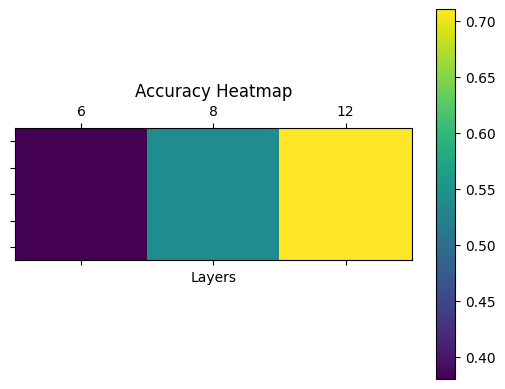

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
# Reshape accuracy data for heatmap
# accuracy_matrix = np.array([score[2] for score in accuracy]).reshape(len(layers_unique), len(heads_unique))

print (accuracy)
scores = np.array(accuracy)

# Plot heatmap
fig, ax = plt.subplots()
cax = ax.matshow(scores, cmap='viridis')

# Add color bar
fig.colorbar(cax)

# Set axis labels
ax.set_xticklabels([''] + list(layers_unique))
ax.set_yticklabels([''])
ax.set_xlabel('Layers')
# ax.set_ylabel('Heads')

# Set title
plt.title('Accuracy Heatmap')
plt.savefig('../plots/mul_accuracy_heatmap.png')
plt.show()